# Code interpreting with Llama 3.1 and Fireworks
This example uses the E2B's [Code Interpreter](https://github.com/e2b-dev/code-interpreter) together with the new [Llama 3.1](https://fireworks.ai/models) models.

We use the [secure sandbox](https://e2b.dev/docs/sandbox/overview) given by E2B to execute code for accomplishing the task given to the LLM.
>

### 1. Installations
First, we install Fireworks, OpenAI, and the E2B Code Interpreter SDK.

In [1]:
%pip install --upgrade fireworks-ai openai e2b_code_interpreter


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 2. Imports and API keys

You need to get your API keys and save them in .env file. You can copy and rename the .env.template file. We import all necessary libraries.

This is what you should put in the .env file:

```sh
# TODO: Get your Fireworks API key from https://fireworks.ai/api-keys
FIREWORKS_API_KEY = "your_api_key"

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = "your_api_key"
```

In [2]:
import openai
import json
import sys
import os
from dotenv import load_dotenv
load_dotenv()

FIREWORKS_API_KEY = os.getenv("FIREWORKS_API_KEY")
E2B_API_KEY = os.getenv("E2B_API_KEY")

### 3. Prompts setup

Now we specify a system prompt, assigning a role to LLM, and user prompt for the task we want to acomplish.

In [3]:
SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS

Generally, you follow these rules:
- ALWAYS FORMAT YOUR RESPONSE IN MARKDOWN
- ALWAYS RESPOND ONLY WITH CODE IN CODE BLOCK LIKE THIS:
```python
{code}
```
- the python code runs in jupyter notebook.
- every time you generate python, the code is executed in a separate cell.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to be running `!pip install {package}`. The usual packages for data analysis are already preinstalled though.
- you can run any python code you want, everything is running in a secure sandbox environment
"""

USER_PROMPT = "Plot a 3D chart of sin x cos y please."

client = openai.OpenAI(
    base_url = "https://api.fireworks.ai/inference/v1",
    api_key = FIREWORKS_API_KEY
)

### 4. Defining the function for running the AI-generated code

We define the `code_interpret` function that uses the [E2B Code Interpreter SDK](https://e2b.dev/docs/code-interpreter/installation) to run AI-generated Python code.

We will use `exec_cell` to execute the AI-generated code inside the code interpreter sandbox.

Learn more about the `exec_cell` method [here](https://e2b.dev/docs/code-interpreter/execution).

In [4]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    # Stream stdout and stderr from the Code Interpreter
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec

### 5. Getting agent's response

Now we define a ```chat``` function that uses one of the Llama 3.1 models to get agent's response to the user's task. You can try it with different LLMs by uncommenting the chosen one. E2B is used to securely run the code.

Because Fireworks doesn't support function calling for Llama 3.1 yet, we instruct the model to return messages in Markdown and then parse and extract the Python code block on our own.

In [5]:

import re
pattern = re.compile(r'```python\n(.*?)\n```', re.DOTALL) # Match everything in between ```python and ```
def match_code_block(llm_response):
  match = pattern.search(llm_response)
  if match:
    code = match.group(1)
    print(code)
    return code
  return ""

from e2b_code_interpreter import CodeInterpreter     

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  def chat(e2b_code_interpreter, user_message):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")
    
    messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
    ]

    response = client.chat.completions.create(
      model = "accounts/fireworks/models/llama-v3p1-405b-instruct",
    # model = "accounts/fireworks/models/llama-v3p1-70b-instruct",
    # model = "accounts/fireworks/models/llama-v3p1-8b-instruct",
    # model = "accounts/fireworks/models/firefunction-v2",
      messages=messages,
    )

    response_message = response.choices[0].message

    python_code = match_code_block(response_message.content)
    if python_code != "":
      code_interpreter_results = code_interpret(e2b_code_interpreter, python_code)
      return code_interpreter_results
    else:
      print(f"Failed to match any Python code in model's response {response_message}")
      return []


### 6. Printing the output

Finally we get the task result, calling the ```chat``` function.

Read more about how the execution with Code Interpreter SDK looks like [here](https://e2b.dev/docs/code-interpreter/execution).


User Message: Plot a 3D chart of sin x cos y please.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D chart of sin x cos y')
plt.show()
Running code interpreter...
Stdout: []
Stderr: []
AI-generated Python runtime error: None
Results: [Result(<Figure size 1000x800 with 1 Axes>)]


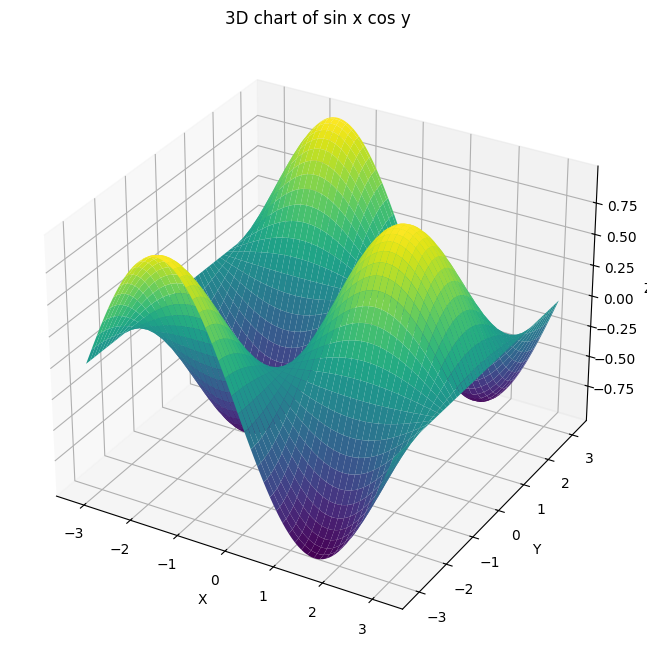

In [6]:
with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  execution_output = chat(
    code_interpreter,
    USER_PROMPT,
  )

  if execution_output == None:
    print("No output from the code interpreter. Did the LLM generate any code?")
    sys.exit(1)

  # Access stdout
  print("Stdout:", execution_output.logs.stdout)
  # Access stderr
  print("Stderr:", execution_output.logs.stderr)

  # Access any runtime errors
  print("AI-generated Python runtime error:", execution_output.error)

  # Access any results of code execution - charts, interpreter last line, images, etc.
  print("Results:", execution_output.results)
  if len(execution_output.results) == 0:
    sys.exit(0)

execution_output.results[0]